In [2]:
#Script to obtain data 
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Dense
from tensorflow.keras.optimizers import SGD
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import compute_class_weight


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
df = pd.read_csv("data/train_2.csv")

In [4]:
col_features = df.columns[6:-2]
print((col_features))
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

Index(['duration', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')


In [5]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)
classWeight = compute_class_weight('balanced', np.unique(encoded_y), encoded_y)
classWeight = dict(enumerate(classWeight))
print(classWeight)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)
# Convert to dummy, no needed for now
# Y_train = np_utils.to_categorical(Y_train)
# Y_test = np_utils.to_categorical(Y_test)
target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[1 3 2 ... 0 3 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.9174497862386061, 1: 2.090163557842507, 2: 0.8652434385697984, 3: 0.7837933291985391}


,mood,encode
6,calm,0
0,energetic,1
2,happy,2
1,sad,3


In [7]:
leaky_relu = LeakyReLU(alpha=0.01)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
opt = SGD(lr=0.01)

def base_model():
    #Create the model
    model = Sequential()
    # Add 1 layer with 8 nodes,input of 4 dim with relu function
    # Oct 1st: Changed to 10 nodes
    # Oct 14th: Changed to 8 nodes, removed the duplicate data
    model.add(Dense(10,input_dim=13,activation='relu'))
    #Add 1 layer with output of 4 and softmax activation function
    model.add(Dense(4,activation='softmax'))
    # model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    # sgd optimizer improve the accuracy on the author's dataset
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [ ]:
# leaky_relu = LeakyReLU(alpha=0.01)
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# opt = SGD(lr=0.01)

# #Create the model
# model = Sequential()
# # Add 1 layer with 8 nodes,input of 4 dim with relu function
# # Oct 1st: Changed to 10 nodes
# # Oct 14th: Changed to 8 nodes, removed the duplicate data
# model.add(Dense(8,input_dim=13,activation='relu'))
# #Add 1 layer with output of 4 and softmax activation function
# model.add(Dense(4,activation='softmax'))
# # model.add(Dense(4,activation='softmax'))
# #Compile the model using sigmoid loss function and adam optim
# # sgd optimizer improve the accuracy on the author's dataset
# model.compile(loss='categorical_crossentropy',optimizer=sgd,
#                 metrics=['accuracy'])

# # Train the model
# model.fit(X_train, Y_train, 
#             batch_size=256, 
#             epochs=300, 
#             verbose=1, 
#             class_weight=classWeight,    
#             validation_data=(X_test, Y_test),
#             shuffle=True)
# model.evaluate(X_test, Y_test, verbose=1)
# y_preds = model.predict(X_test)

In [9]:
#Configure the model
# increase batch size for the warning: WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update
estimator = KerasClassifier(build_fn=base_model,epochs=30,batch_size=512,verbose=1)

In [11]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
# results = cross_val_score(estimator,X,encoded_y,cv=kfold)
results = cross_val_score(estimator,X,dummy_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Train on 81890 samples
Epoch 1/30
81890/81890 [==============================] - 0s 4us/sample - loss: 1.3363 - acc: 0.3137
Epoch 2/30
81890/81890 [==============================] - 0s 4us/sample - loss: 1.2252 - acc: 0.4498
Epoch 3/30
81890/81890 [==============================] - 0s 6us/sample - loss: 1.1796 - acc: 0.4758
Epoch 4/30
81890/81890 [==============================] - 0s 6us/sample - loss: 1.1616 - acc: 0.4870
Epoch 5/30
81890/81890 [==============================] - 0s 5us/sample - loss: 1.1530 - acc: 0.4920
Epoch 6/30
81890/81890 [==============================] - 0s 5us/sample - loss: 1.1481 - acc: 0.4951
Epoch 7/30
81890/81890 [==============================] - 0s 5us/sample - loss: 1.1447 - acc: 0.4979
Epoch 8/30
81890/81890 [==============================] - 0s 6us/sample - loss: 1.1421 - acc: 0.4992
Epoch 9/30
81890/81890 [==============================] - 0s 5us/sample - loss: 1.1401 - acc: 0.5007
Epoch 10/30
81890/81890 [==============================] - 0s 5us/sa

In [13]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)
# y_preds = np.argmax(estimator.predict(X_test), axis=-1)
len(y_preds)

Train on 72791 samples
Epoch 1/30
72791/72791 [==============================] - 1s 8us/sample - loss: 1.3358 - acc: 0.3578
Epoch 2/30
72791/72791 [==============================] - 1s 8us/sample - loss: 1.2347 - acc: 0.4705
Epoch 3/30
72791/72791 [==============================] - 0s 5us/sample - loss: 1.1809 - acc: 0.4875
Epoch 4/30
72791/72791 [==============================] - 0s 5us/sample - loss: 1.1628 - acc: 0.4924
Epoch 5/30
72791/72791 [==============================] - 0s 5us/sample - loss: 1.1562 - acc: 0.4949
Epoch 6/30
72791/72791 [==============================] - 1s 14us/sample - loss: 1.1531 - acc: 0.4960
Epoch 7/30
72791/72791 [==============================] - 1s 9us/sample - loss: 1.1513 - acc: 0.4971
Epoch 8/30
72791/72791 [==============================] - 0s 6us/sample - loss: 1.1501 - acc: 0.4978
Epoch 9/30
72791/72791 [==============================] - 0s 6us/sample - loss: 1.1492 - acc: 0.4982
Epoch 10/30
72791/72791 [==============================] - 0s 4us/s

18198

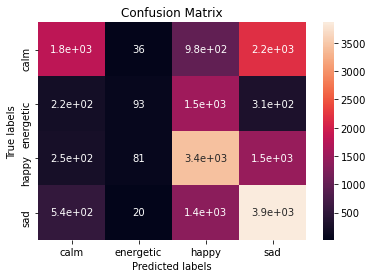

Accuracy Score 0.5055500604462029


In [14]:

cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [15]:
preds = get_songs_features('7J0JC8aTQB6Di3874t0fuk')
print(preds)
preds_features = np.array(preds[0][6:]).reshape(-1,1).T
print(preds_features)
X = MinMaxScaler().fit_transform(preds_features)
print(X)

(['TWILIGHT IN UPPER WEST', 'TRUTH', 'T-SQUARE', '7J0JC8aTQB6Di3874t0fuk', '1987-04-01', 24, 325306, 0.468, 0.325, 10, -8.148, 1, 0.0304, 0.29, 0.385, 0.158, 0.0788, 129.735, 4], ['name', 'album', 'artist', 'id', 'release_date', 'popularity', 'duration', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'])
[[ 3.25306e+05  4.68000e-01  3.25000e-01  1.00000e+01 -8.14800e+00
   1.00000e+00  3.04000e-02  2.90000e-01  3.85000e-01  1.58000e-01
   7.88000e-02  1.29735e+02  4.00000e+00]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:

def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,   epochs=30,
                                                                             batch_size=512,verbose=0))])
    # pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',estimator)])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")
    

In [18]:
predict_mood('2UYdqPzh5pnfjtb6kW4tsi')

木綿のハンカチーフ by Jun Shibata is a SAD song
